In [1]:
import numpy
import pandas
import scipy.misc, scipy.stats
import seaborn
import sys
from collections import defaultdict

seaborn.set_style("white")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Overview

I aligned the raw sequences to a single reference sequence representing the merged allele, with only shared sequence (see `ref.fa` and `commands.sh`):

    ATCTCTTTTCTTCTCTGTGCGAGGATTTGGACTGGCAGTG

I changed the SNP to a third base (`G`) so that neither allele would match it.

I used the CIGAR string from the read alignments to generate "mutation profiles" for each read, where `1` is a mutation and `0` is not.  I assign `?` if the read did not align in that position (see `sam_to_binary_counts.py`).  For example:

    0000000000000000100000000000000000000000
    0000000000000000100000000000000100000000
    0000000000000101100000000000000000000000
    0000000000000000100000000000000000000000
    000000000000000010000000001000??????????

I load those string mutation profiles below and cluster them based on vectors of mutation probabilities, which are learned simultaneously.

I only consider reads that have more than 2 mutations, in order to get reads that give useful joint information across positions (the masked SNP in the middle counts as 1).

The clustering procedure is fairly sensitive to the (random) initialization of the mutation probability vectors, so multiple restarts are needed.

After clustering finishes, I compare the predicted cluster membership probabilities with the assigned allele (see `sam_to_allele_labels.py`).

## Load file of bit vector representations

In [142]:
# load from full annotated file and do filtering here (and keep labels for downstream validation)
prefix = "/cluster/matted/ribosnitch_silvi/"
annotated = pandas.read_csv(prefix + "OC57_index2_S2_L002_R1_001.fastq.ribosmall.realigned.bitvectors.gt2.txt",
                            # "realigned_bitvectors.txt",
                            sep=" ",
                            names=["name", "bitvector", "mutations", "label"])

print annotated.shape

annotated = annotated[annotated["mutations"] > 2] # only consider reads with >2 mutations

x = []
for line in annotated["bitvector"].values:
    x.append(list(line.strip()))
x = pandas.DataFrame(numpy.asarray(x))
x.replace(["0", "1", "?"], [0.0, 1.0, numpy.nan], inplace=True)

mask = (x.notnull().mean(axis=1) > 0.9).values

x = x[mask]
annotated = annotated[mask]

x = x.iloc[:50000]
annotated = annotated.iloc[:len(x)]

print x.shape, annotated.shape

(2341995, 4)
(50000, 40) (50000, 4)


In [3]:
# load allele labels that follow silvi's method
prefix = "/cluster/matted/ribosnitch_silvi/"
labels = pandas.read_csv(prefix + "OC57_index2_S2_L002_R1_001.strip.ribosmall.1mill.assigned.txt",
                            sep=" ",
                            names=["name", "silvi_label"])
try:
    del annotated["silvi_label"]
except KeyError:
    pass

print annotated.shape
annotated = pandas.merge(annotated, labels, left_on="name", right_on="name", how="left")
print annotated.shape
annotated.head(3)

(20551, 4)
(20551, 5)


,name,bitvector,mutations,label,silvi_label
0,K00153:60:H3HK3BBXX:2:1101:5507:1156,0000000000000101100000000000000000000000,3,A,A
1,K00153:60:H3HK3BBXX:2:1101:9100:1156,0000000001100000100000000000000000000000,3,C,C
2,K00153:60:H3HK3BBXX:2:1101:11353:1156,0001000000010000100000000000000000000000,3,A,A


In [4]:
annotated.groupby(["label", "silvi_label"])[["name"]].count()

name
label silvi_label       
A     ?                1
      A            14320
      C                4
C     ?                5
      A              345
      C             5432
G     A               14
      C                9
T     ?                5
      A              405
      C               11

In [143]:
# mark the column with the known SNP as missing, so that later plots are simpler
if len((x.mean(axis=0) > 0.5).nonzero()[0]) > 0:
    excluded_column = (x.mean(axis=0) > 0.5).nonzero()[0][0]
    x[excluded_column] = numpy.nan
    
# exclude columns that very rarely see mutations (probably just errors there)
if False:
    x[x.columns[(x.mean(axis=0) <= 0.01).values].values] = numpy.nan

In [128]:
# only consider A or C bases in the reference
ref = "ATCTCTTTTCTTCTCTGTGCGAGGATTTGGACTGGCAGTG"
assert len(ref) == len(x.columns)

for column in x.columns.values:
    base = ref[column]
    if base != "A" and base != "C":
        del x[column]
        
print x.columns.values

[ 0  2  4  9 12 14 19 21 24 30 31 35 36]


In [6]:
# or just use simulated data (overwrites previously loaded stuff)
if False:
    n = 10000
    p = 3
    x = numpy.zeros((n, p))

    x[:2*n/3, 0] = scipy.stats.bernoulli.rvs(0.2, size=2*n/3)
    x[:2*n/3:, 1] = scipy.stats.bernoulli.rvs(0.8, size=2*n/3)
    x[:2*n/3:, 2] = scipy.stats.bernoulli.rvs(0.1, size=2*n/3)

    x[-n/3+1:, 0] = scipy.stats.bernoulli.rvs(0.8, size=n/3)
    x[-n/3+1:, 1] = scipy.stats.bernoulli.rvs(0.2, size=n/3)
    x[-n/3+1:, 2] = scipy.stats.bernoulli.rvs(0.7, size=n/3)

    x = pandas.DataFrame(x)

## Visualize the data

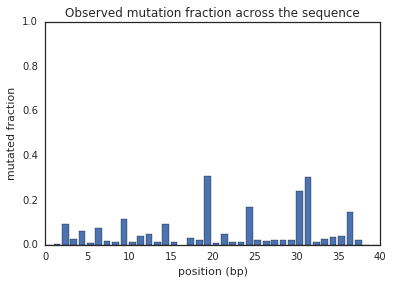

In [144]:
pylab.bar(x.columns.values, x.mean(axis=0))
pylab.ylim(0, 1)
pylab.ylabel("mutated fraction")
pylab.xlabel("position (bp)")
pylab.title("Observed mutation fraction across the sequence")
pylab.show()

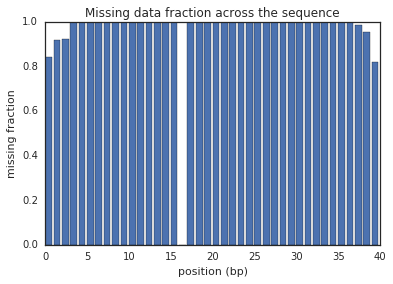

In [153]:
pylab.bar(x.columns.values, x.notnull().mean(axis=0))
pylab.ylim(0, 1)
pylab.ylabel("missing fraction")
pylab.xlabel("position (bp)")
pylab.title("Missing data fraction across the sequence")
pylab.show()

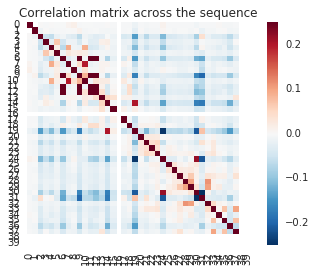

In [146]:
seaborn.heatmap(x.corr(), square=True, vmax=0.25, vmin=-0.25)
pylab.title("Correlation matrix across the sequence")
pylab.show()

## Cluster the reads by per-base mutation frequency

This is (multivariate) Bernoulli mixture model clustering via expectation maximization (EM).

See this writeup for a good overview: https://nsgrantham.github.io/documents/clustering-binary-data.pdf.

In [10]:
def binary_loglik(observed, probs):
    lik = scipy.stats.bernoulli.logpmf(observed, probs)
    # ignore nan values
    lik = lik[numpy.isfinite(lik)]
    return numpy.sum(lik)

In [47]:
def plot_cluster(clusters, cluster_probs, loglik, its, positions, d):
    for j in xrange(d):
        pylab.plot(positions, clusters[j], 'o--', 
                   label="class %d ($p_%d=%.3f$)" % (j+1, j+1, cluster_probs[j], ))
    pylab.ylim(0, 1)
    pylab.ylabel("mutation probability")
    pylab.xlabel("position (bp)")    
    pylab.legend(loc="upper center")
    pylab.title("%d clusters, iteration %d, loglik=%.2f" % (d, its+1, loglik))
    pylab.show()

In [52]:
# d is number of clusters
# x is binary data vectors to cluster (point are rows)
#
# a and b are beta distribution parameters for a prior on
# per-base mutation frequencies when re-estimating from
# observed data interpretation is positive (mutated) and
# negative (non-mutated) pseudo-counts 0.0 for both means
# we're just doing MLE instead of MAP
def cluster_data(x, d, a=0.0, b=0.0, max_its=20, verbose=False):
    p = x.shape[1]
    n = x.shape[0]
    
    # clusters = [scipy.stats.uniform.rvs(0, 1, size=p) for i in xrange(d)]
    clusters = [scipy.stats.beta.rvs(2, 2, size=p) for i in xrange(d)]
    cluster_probs = numpy.asarray([1.0/d] * d)

    responsibilities = numpy.zeros((n, d))

    last_loglik = -numpy.inf

    for its in xrange(max_its):
        ### (probabilistically) assign reads to clusters
        loglik = 0.0
        for i in xrange(n):
            if i % 10000 == 0 and verbose: print >>sys.stderr, "\t", i
            for j in xrange(d):
                responsibilities[i, j] = numpy.log(cluster_probs[j]) + binary_loglik(x.iloc[i].values, clusters[j])
            # normalize the class responsibilities for this read:
            # responsibilities[i, :] -= numpy.log(numpy.sum(numpy.exp(responsibilities[i, :]))) 
            # numerically stable version:
            temp = scipy.misc.logsumexp(responsibilities[i, :])
            loglik += temp
            responsibilities[i, :] -= temp

        responsibilities = numpy.exp(responsibilities)
        cluster_probs = numpy.nanmean(responsibilities, axis=0)

        ### re-estimate cluster parameters
        for j in xrange(d):
            for k in xrange(p):
                clusters[j][k] = ((a + numpy.nansum(responsibilities[:, j] * x.values[:, k])) / 
                                  (a + b + numpy.nansum(responsibilities[:, j] * numpy.isfinite(x.values[:, k]))))

        ### visualize cluster parameters at each iteration
        if verbose or its + 1 == max_its:
            print >>sys.stderr, "*** iteration", its + 1, loglik
            # plot_cluster(clusters, cluster_probs, loglik, its, x.columns.values, d)
        
        # if the likelihood has converged (locally), stop iterating
        if numpy.abs(loglik - last_loglik) < 0.01:
            break
        last_loglik = loglik
        
    # TODO: consider reordering clusters by cluster_probs, to avoid label permutation problem?
    return clusters, cluster_probs, responsibilities, loglik

	0
	10000
	20000
	30000
	40000
*** 1 -1579432.80538
	0
	10000
	20000
	30000
	40000
*** 2 -334413.217873
	0
	10000
	20000
	30000
	40000
*** 3 -322042.101462
	0
	10000
	20000
	30000
	40000
*** 4 -315133.46398
	0
	10000
	20000
	30000
	40000
*** 5 -311598.782228
	0
	10000
	20000
	30000
	40000
*** 6 -310286.543215
	0
	10000
	20000
	30000
	40000
*** 7 -309817.540965
	0
	10000
	20000
	30000
	40000
*** 8 -309641.717697
	0
	10000
	20000
	30000
	40000
*** 9 -309555.176259
	0
	10000
	20000
	30000
	40000
*** 10 -309501.549304
	0
	10000
	20000
	30000
	40000
*** 11 -309464.312893
	0
	10000
	20000
	30000
	40000
*** 12 -309437.098559
	0
	10000
	20000
	30000
	40000
*** 13 -309416.766235
	0
	10000
	20000
	30000
	40000
*** 14 -309401.416418
	0
	10000
	20000
	30000
	40000
*** 15 -309389.712606
	0
	10000
	20000
	30000
	40000
*** 16 -309380.655334
	0
	10000
	20000
	30000
	40000
*** 17 -309373.50222
	0
	10000
	20000
	30000
	40000
*** 18 -309367.717542
	0
	10000
	20000
	30000
	40000
*** 19 -309362.922847
	0
	

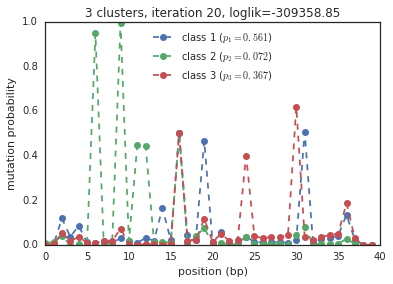

In [156]:
d = 3
clusters, cluster_probs, responsibilities, loglik = cluster_data(x, d=d, a=1.0, b=1.0, verbose=True, max_its=20)
plot_cluster(clusters, cluster_probs, loglik, 20-1, x.columns.values, d=d)

# 2 classes, loglik = -319842.969866
# 2 classes, loglik = -325658.459457 (looks good though)
# 2 classes, loglik = -324203.517192 (looks good also)
# 3 classes, loglik = -321254.114315 (looks good? maybe not)
# 3 classes, loglik = -315433.52116 (looks funky)
# 3 classes, loglik = -309358.851474 (looks the best! yay)

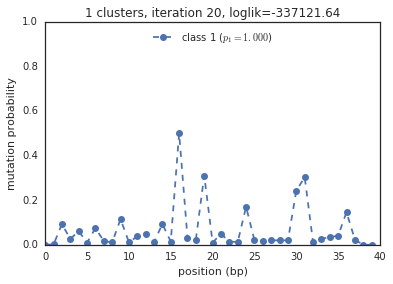

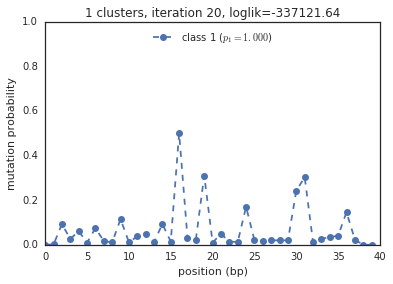

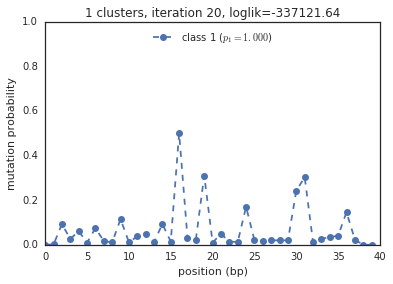

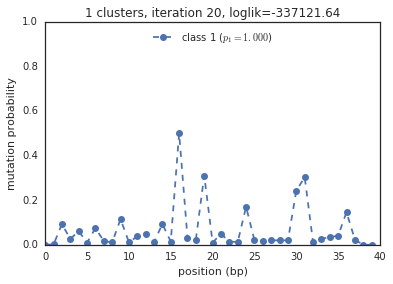

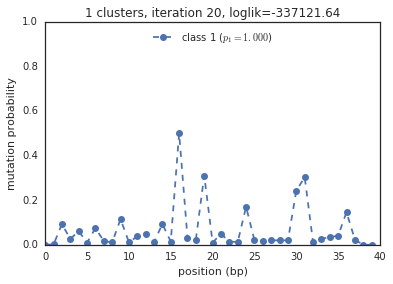

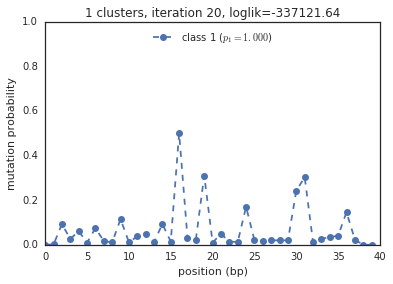

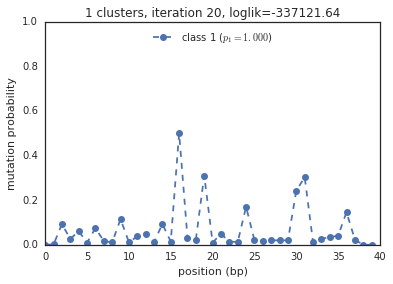

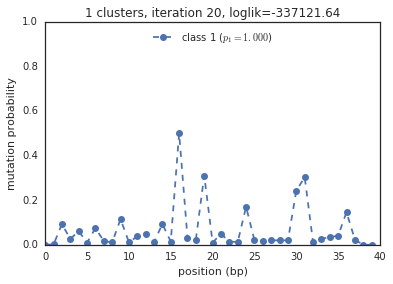

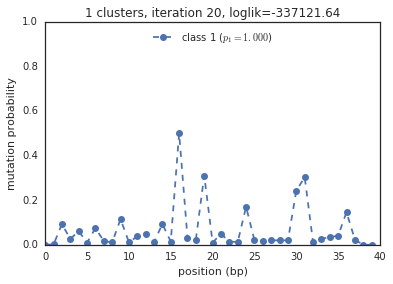

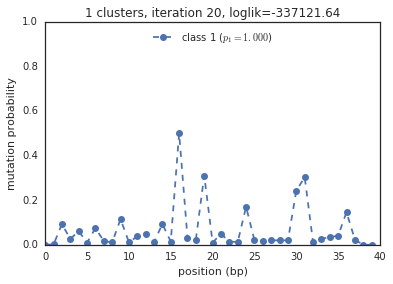

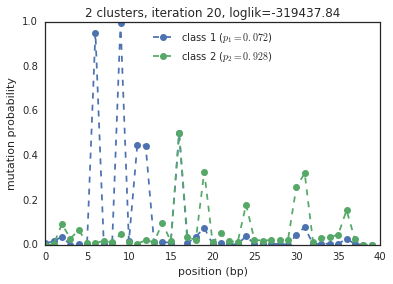

*** 20 -319908.419199


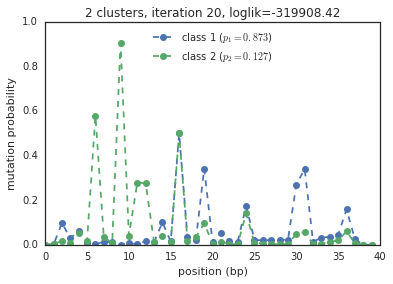

*** 20 -324178.653297


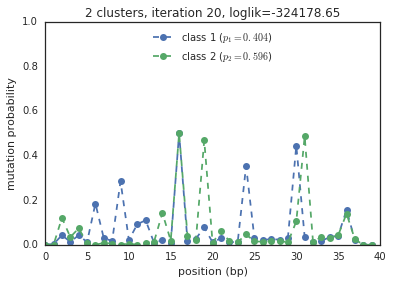

*** 20 -325705.559187


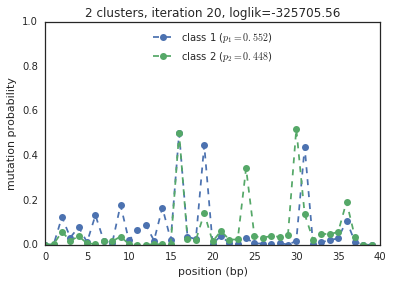

*** 20 -325665.360899


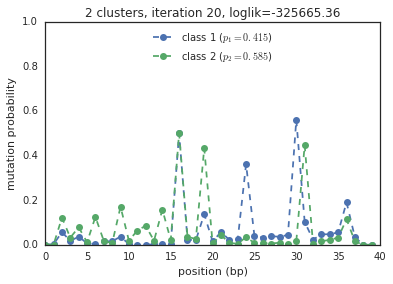

*** 20 -324203.44785


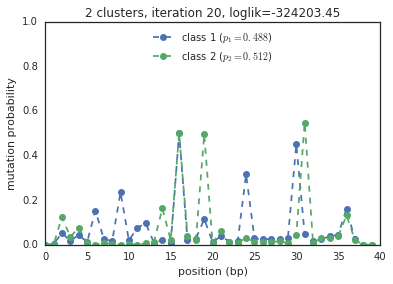

*** 20 -326175.112021


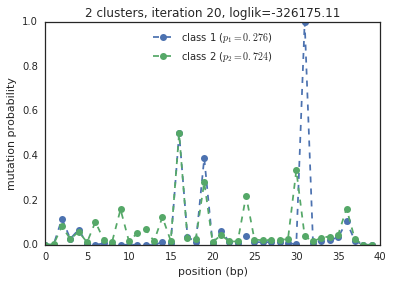

*** 20 -324160.715766


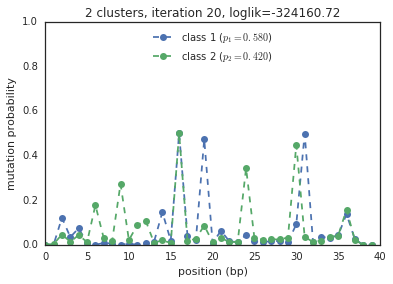

*** 20 -319788.336654


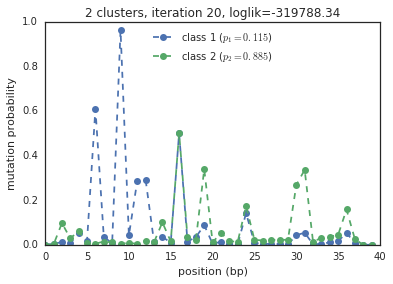

*** 20 -319895.910817


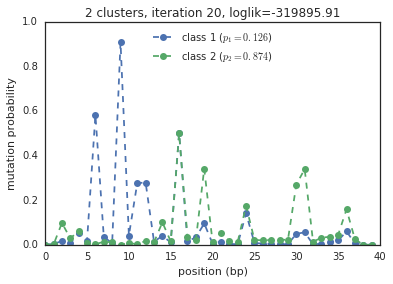

*** 20 -313507.928746


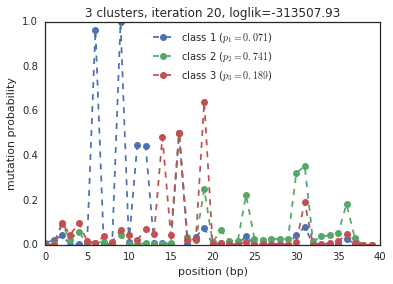

*** 20 -319859.12332


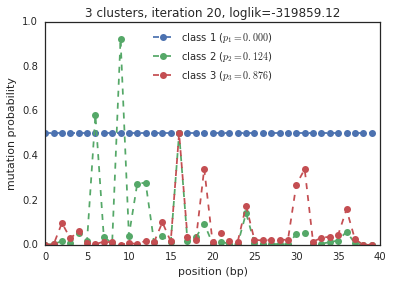

*** 20 -309801.92928


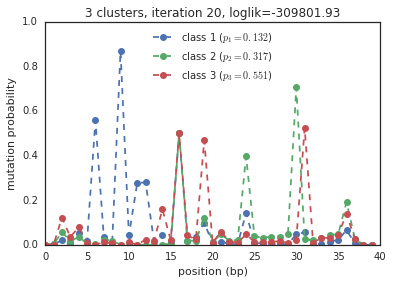

*** 20 -309603.219066


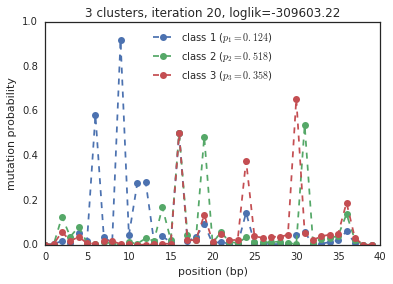

*** 20 -312285.312579


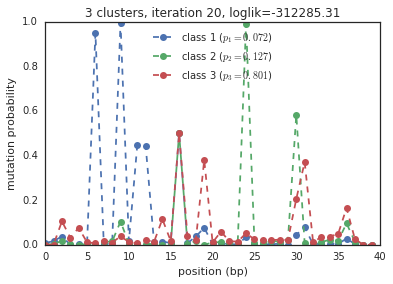

*** 20 -309541.543179


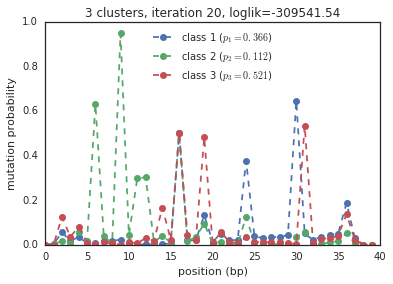

*** 20 -309326.687808


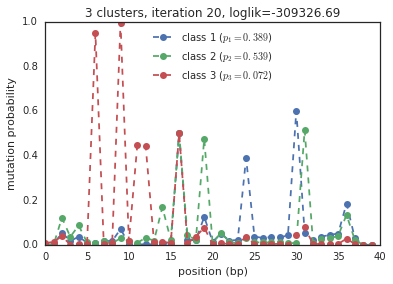

*** 20 -317303.339334


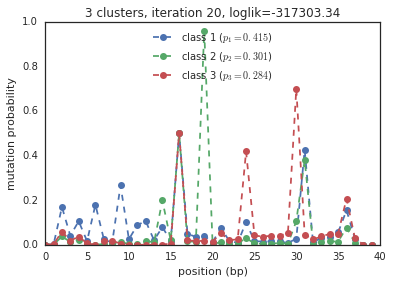

*** 20 -309766.667237


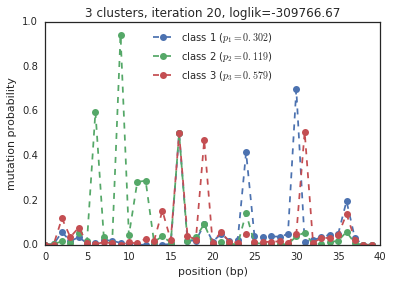

*** 20 -317627.000995


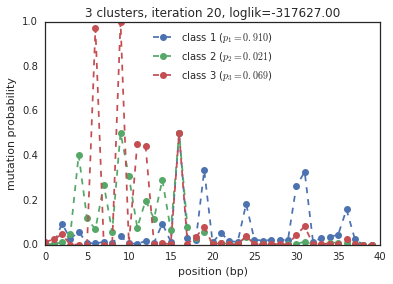

*** 20 -305371.524705


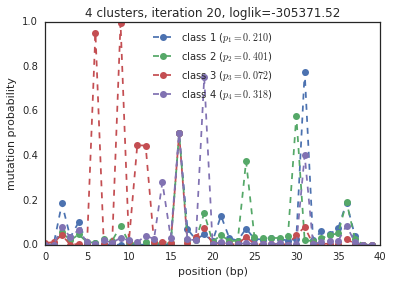

*** 20 -307089.28789


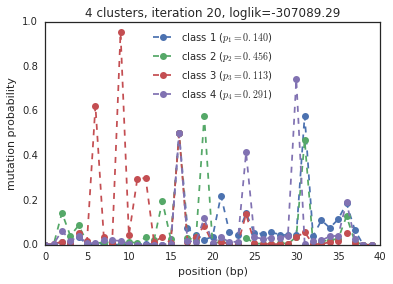

*** 20 -307839.33517


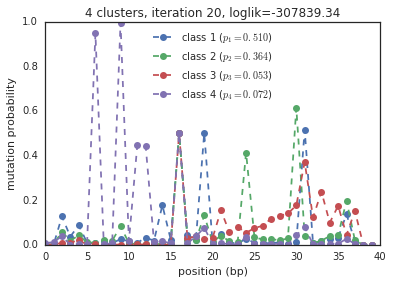

*** 20 -304106.012161


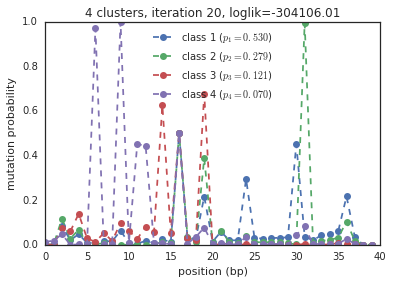

*** 20 -310848.892532


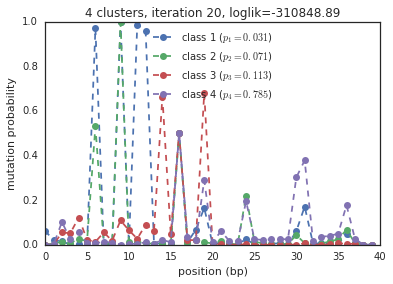

*** 20 -302675.324236


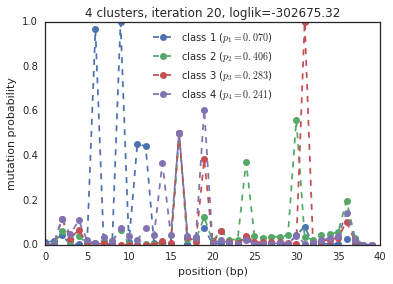

*** 20 -302911.920694


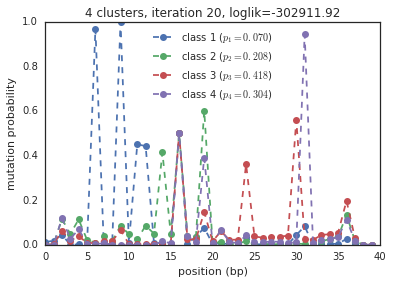

*** 20 -302696.323844


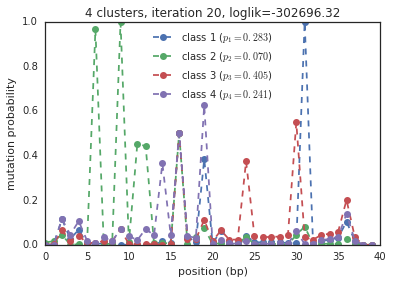

*** 20 -307765.322549


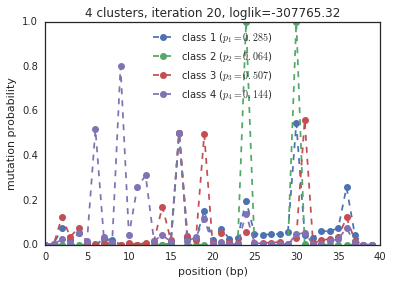

*** 20 -307665.95502


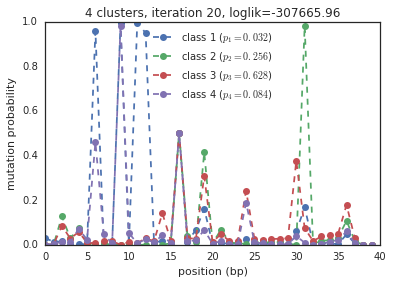

*** 20 -304129.06424


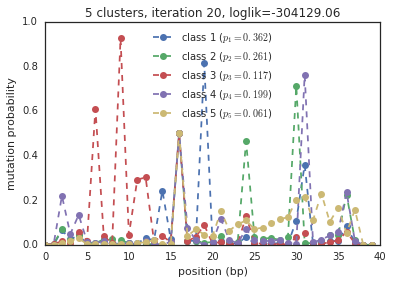

*** 20 -305360.689617


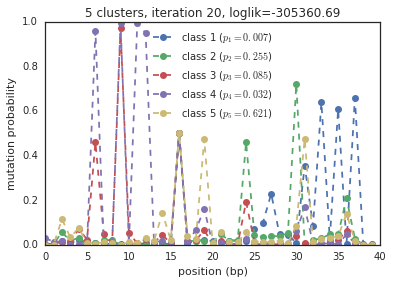

*** 20 -323373.063397


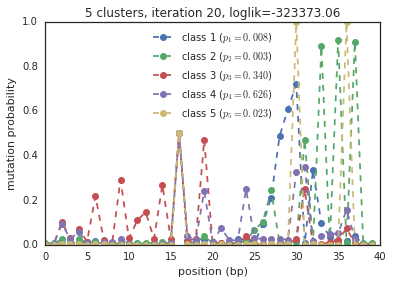

*** 20 -305046.403649


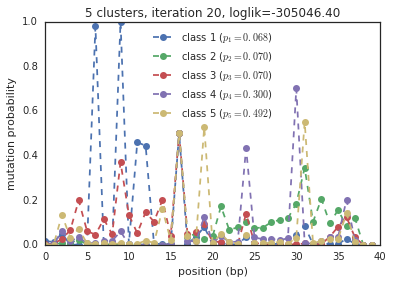

*** 20 -300687.302572


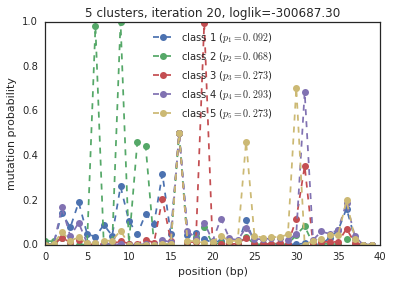

*** 20 -305451.662149


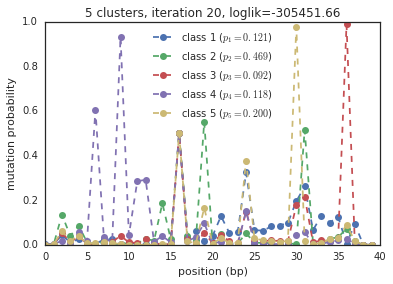

*** 20 -301442.494722


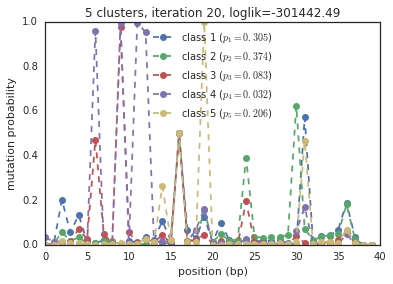

*** 20 -300500.51491


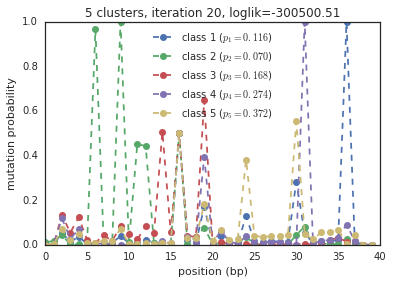

*** 20 -307612.754393


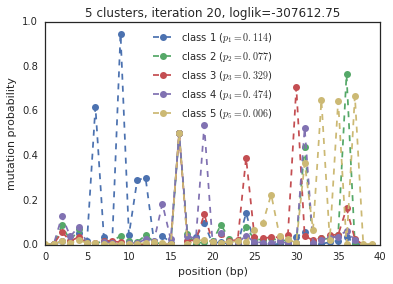

*** 20 -303057.686361


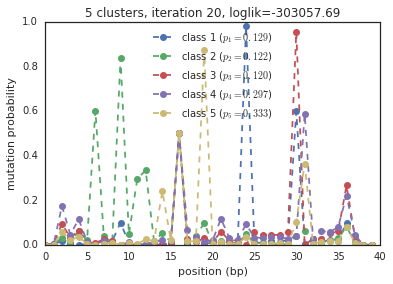

*** 20 -299467.592231


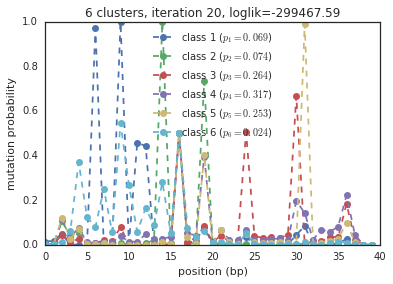

*** 20 -301488.634117


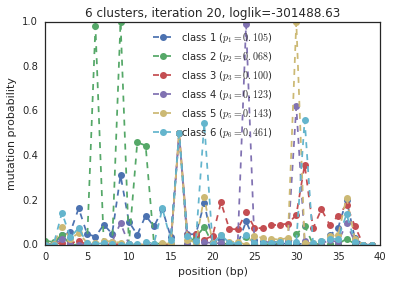

*** 20 -300080.774307


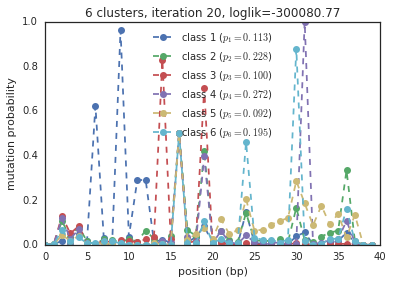

*** 20 -301516.147419


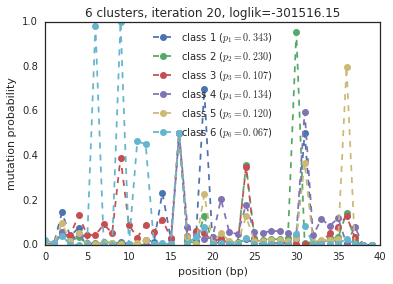

*** 20 -304650.299732


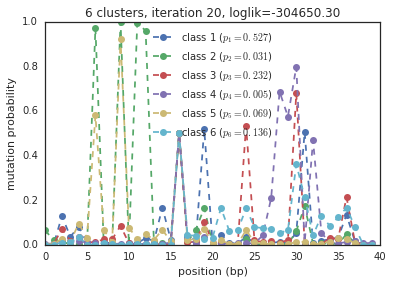

*** 20 -304364.052108


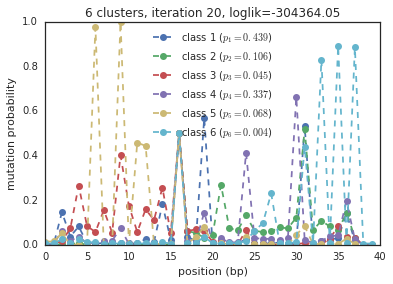

*** 20 -303660.724283


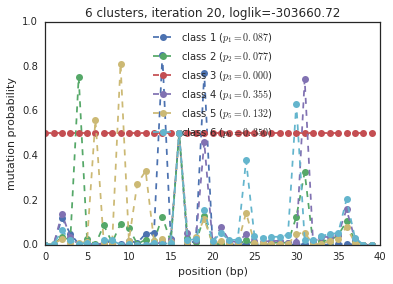

*** 20 -308175.741025


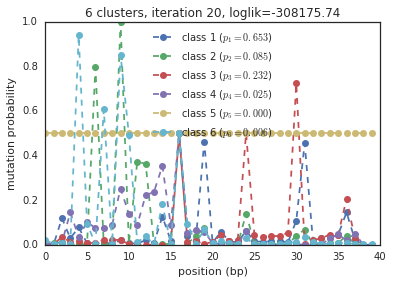

*** 20 -304699.489572


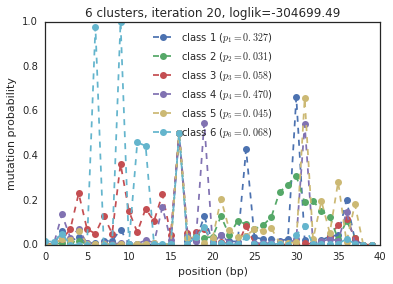

*** 20 -305649.88067


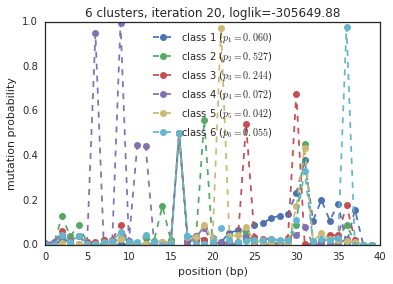

,BIC,k,loglik,smallest cluster
0,674254.100115,1,-337121.640168,1.000000e+00
1,674254.100115,1,-337121.640168,1.000000e+00
2,674254.100115,1,-337121.640168,1.000000e+00
3,674254.100115,1,-337121.640168,1.000000e+00
4,674254.100115,1,-337121.640168,1.000000e+00
5,674254.100115,1,-337121.640168,1.000000e+00
6,674254.100115,1,-337121.640168,1.000000e+00
7,674254.100115,1,-337121.640168,1.000000e+00
8,674254.100115,1,-337121.640168,1.000000e+00
9,674254.100115,1,-337121.640168,1.000000e+00


In [180]:
max_its = 20
metrics = defaultdict(list)

for d in [1, 2, 3, 4, 5, 6]:
    for replicates in xrange(10): # was 5
        clusters, cluster_probs, responsibilities, loglik = cluster_data(x, d, a=1.0, b=1.0, verbose=False, max_its=max_its)
        plot_cluster(clusters, cluster_probs, loglik, max_its-1, x.columns.values, d)
        metrics["k"].append(d)
        metrics["loglik"].append(loglik)
        metrics["BIC"].append(-2.0*loglik + d*numpy.log(len(x)))
        metrics["smallest cluster"].append(numpy.min(cluster_probs))
        
metrics = pandas.DataFrame(metrics)
metrics

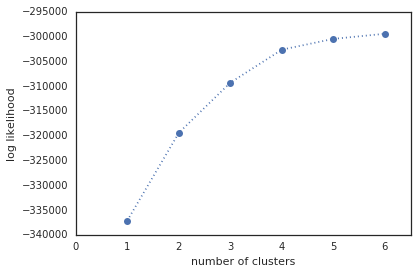

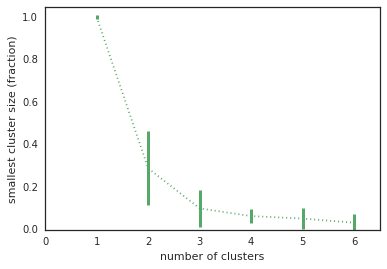

,BIC,loglik,smallest cluster,negative BIC
k,,,,
1,674254.100115,-337121.640168,1.000000,-674254.100115
2,652371.863599,-319437.844549,0.487760,-638897.328655
3,639750.705975,-309326.687808,0.283980,-618685.834951
4,621741.064178,-302675.324236,0.112939,-605393.927586
5,646800.225685,-300500.514910,0.119900,-601055.128710
6,616416.400720,-299467.592231,0.092011,-599000.103132


In [188]:
metrics["negative BIC"] = -metrics["BIC"]
grouped = metrics.groupby("k").max()

# print numpy.log(len(x))
pylab.plot(grouped.index.values, grouped["loglik"], "o:")
# pylab.twinx()
# pylab.plot(grouped.index.values, grouped["negative BIC"], "o:")
pylab.xlim(0, 6.5)
pylab.xlabel("number of clusters")
pylab.ylabel("log likelihood")
pylab.show()

sizes = metrics.groupby("k")["smallest cluster"]
pylab.errorbar(sizes.mean().index.values, sizes.mean().values, yerr=1e-2 + sizes.std().values, elinewidth=3, ls=":", color=seaborn.color_palette()[1])
pylab.xlim(0, 6.5)
pylab.ylim(0, 1.05)
pylab.xlabel("number of clusters")
pylab.ylabel("smallest cluster size (fraction)")
pylab.show()

# TODO: consider also plotting something like "size of smallest cluster [for best parameters]?
# would be kind of interesting...

grouped

## Visualize the final clusters and read assignments

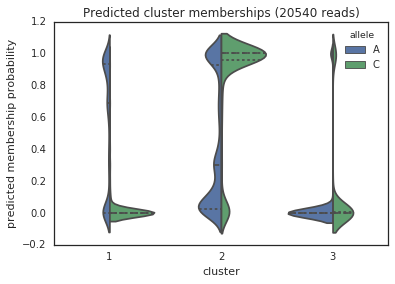

In [13]:
# exclude reads that we couldn't label successfully
mask = (annotated["silvi_label"] != "?").values # & (annotated["silvi_label"] == annotated["label"]).values

prob_label = "predicted membership probability"

combined = defaultdict(list)
for j in xrange(d):
    combined["allele"].extend(annotated["silvi_label"].values[mask])
    combined[prob_label].extend(responsibilities[:,j][mask])
    combined["cluster"].extend([str(j+1)]*mask.sum())
    
combined = pandas.DataFrame(combined)

seaborn.violinplot(y=prob_label, x="cluster", hue="allele", split=True, inner="quartile", data=combined)
pylab.title("Predicted cluster memberships (%d reads)" % mask.sum())
pylab.show()

# combined.tail()

In [14]:
temp = annotated[["name", "silvi_label", "label"]].copy()
predicted_cluster = []

for i in xrange(n):
    predicted_cluster.append(responsibilities[i, :].argmax() + 1)

temp["predicted_cluster"] = predicted_cluster
temp.groupby(["silvi_label", "predicted_cluster"]).count()[["name"]]

name
silvi_label predicted_cluster      
?           1                     1
            2                     3
            3                     7
A           1                  8821
            2                  5567
            3                   696
C           1                   170
            2                  4534
            3                   752

In [43]:
temp = annotated.copy()
temp["cluster 3 prob."] = responsibilities[:,2]

display(temp[temp["cluster 3 prob."] > 0.9999].groupby("bitvector").count()[["name"]].sort_values(by="name", ascending=False).head())

display(temp.sort_values(by="cluster 3 prob.", ascending=False).head(10))

prefix = "/cluster/matted/ribosnitch_silvi"
temp[temp["cluster 3 prob."] > 0.999999][["name"]].to_csv(prefix + "/cluster3_readnames.txt", header=False, index=False)


,name
bitvector,
???0001001011000100000000000000000000000,188
???0001001011000100000000000000100000000,106
???0001001011000100100000000000000000000,98
???0001001011000100000000000001000000000,41
???0001001011000101000000000000000000000,38


,name,bitvector,mutations,label,silvi_label,cluster 3 prob.
12059,K00153:60:H3HK3BBXX:2:1101:16092:34618,???0001001011000101000000000000000000000,6,C,A,1
3260,K00153:60:H3HK3BBXX:2:1101:28392:9543,???0001001011000101000000000000000000000,6,A,C,1
18267,K00153:60:H3HK3BBXX:2:1102:19035:4796,???0001001011000101000000000000000000000,6,C,C,1
16147,K00153:60:H3HK3BBXX:2:1101:25915:46680,???0001001011000101000000000000000000000,6,C,A,1
8527,K00153:60:H3HK3BBXX:2:1101:27326:24437,???0001001011000101000000000000000000000,6,C,C,1
16815,K00153:60:H3HK3BBXX:2:1101:9577:48544,???0001001011000101000000000000000000000,6,C,A,1
12961,K00153:60:H3HK3BBXX:2:1101:9678:37431,???0001001011000101000000000000000000000,6,C,C,1
696,K00153:60:H3HK3BBXX:2:1101:17523:2738,???0001001011000101000000000000000000000,6,C,A,1
6120,K00153:60:H3HK3BBXX:2:1101:9688:17509,???0001001011000101000000000000000000000,6,C,C,1
10046,K00153:60:H3HK3BBXX:2:1101:26819:28692,???0001001011000101000000000000000000000,6,C,C,1


## Random extra plots for testing

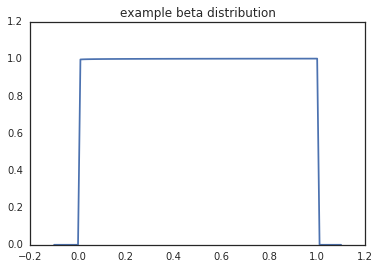

In [97]:
xvals = numpy.arange(-0.1, 1.1, 0.01)
pylab.plot(xvals, scipy.stats.beta.pdf(xvals, 1.001, 1.0))
pylab.title("example beta distribution")
pylab.show()